# Pathway activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering pathway activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for pathway activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

scRNA-seqは、それだけでは解釈が難しい多くの分子リードアウトをもたらす。この情報を要約する1つの方法は、事前知識からパスウェイ活性を推測することである。

このノートブックでは、3k PBMC 10Xデータセットを用いて、パスウェイ活性推論にdecouplerを使用する方法を紹介します。このデータは、健康なドナーの3k PBMCから構成されており、10x Genomics社からこのウェブページから自由に入手できます。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、scRNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
import scanpy as sc

In [2]:
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
import decoupler as dc

## Loading the data

We can download the data easily using `scanpy`:

データはscanpyを使って簡単にダウンロードできる：

In [4]:
adata = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [5]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

私たちはその中で、さまざまな種類の細胞を可視化することができる：

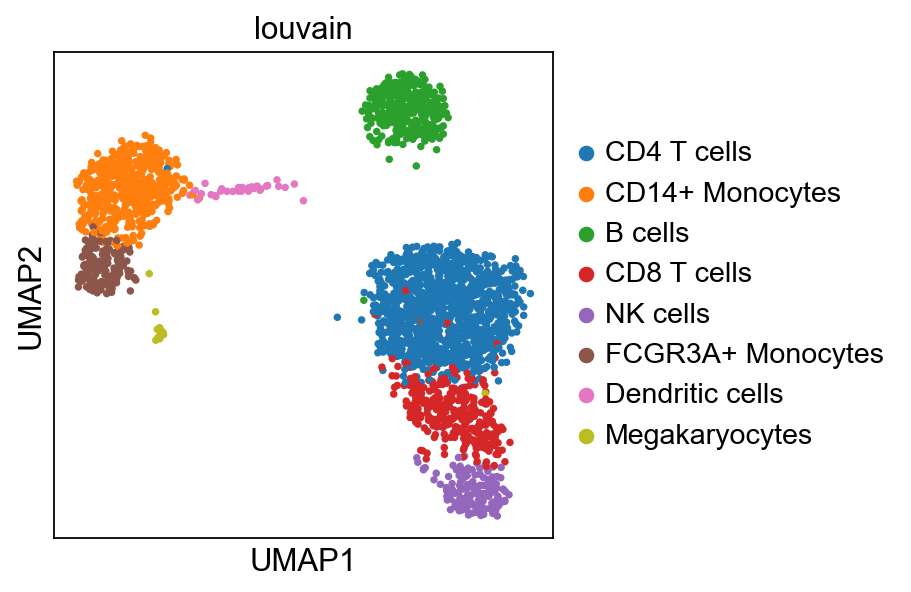

In [6]:
sc.pl.umap(adata, color='louvain')

In [8]:
dc.show_resources()

['Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CSPA',
 'CSPA_celltype',
 'CancerDrugsDB',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCall',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'CellTypist',
 'Cellinker',
 'Cellinker_complex',
 'ComPPI',
 'CytoSig',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'InterPro',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'Lambert2018',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'PROGENy',
 'PanglaoDB',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniProt_keyword',
 'Un

In [10]:
dc.show_methods()

,Function,Name
0,run_aucell,AUCell.
1,run_consensus,Consensus score from top methods.
2,run_gsea,Gene Set Enrichment Analysis (GSEA).
3,run_gsva,Gene Set Variation Analysis (GSVA).
4,run_mdt,Multivariate Decision Tree (MDT).
5,run_mlm,Multivariate Linear Model (MLM).
6,run_ora,Over Representation Analysis (ORA).
7,run_udt,Univariate Decision Tree (UDT).
8,run_ulm,Univariate Linear Model (ULM).
9,run_viper,Virtual Inference of Protein-activity by Enric...


In [11]:
dc.show_metrics()

,Function,Name
0,metric_auprc,Area Under the Precision-Recall Curve (AUPRC)
1,metric_auroc,Area Under the Receiver Operating characterist...
2,metric_mcauprc,Monte-Carlo Area Under the Precision-Recall Cu...
3,metric_mcauroc,Monte-Carlo Area Under the Receiver Operating ...
4,metric_nrank,Min-max normalized rank (from 0 to 1)
5,metric_rank,Rank (from 1 to N)
6,metric_recall,Recall. Assumes y_true has been filtered by p-...


## PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

PROGENyは、パスウェイとその標的遺伝子のキュレーションコレクションを含む包括的なリソースで、各相互作用の重み付けがある。この例ではヒトの重みを使用し（他の生物も利用可能）、p値でランク付けされた上位500の応答遺伝子を使用する。以下に各経路の簡単な説明をする：

- アンドロゲン：男性生殖器の成長と発達に関与する。
- EGFR：哺乳類細胞の成長、生存、遊走、アポトーシス、増殖、分化を制御する。
- エストロゲン：女性の生殖器の成長と発達を促進する。
- 低酸素：酸素濃度が低い場合、血管新生と代謝の再プログラミングを促進する。
- JAK-STAT：免疫、細胞分裂、細胞死、腫瘍形成に関与する。
- MAPK：外部シグナルを統合し、細胞の成長と増殖を促進する。
- NFkB：免疫応答、サイトカイン産生、細胞生存を制御する。
- p53：細胞周期、アポトーシス、DNA修復、腫瘍抑制を制御する。
- PI3K：成長と増殖を促進する。
- TGFb：ほとんどの組織の発生、恒常性維持、修復に関与する。
- TNFa：造血、免疫監視、腫瘍退縮、感染防御を媒介する。
- トレイル：アポトーシスを誘導する。
- VEGF：血管新生、血管透過性、細胞移動を媒介する。
- WNT：発生と組織修復における器官の形態形成を制御する。

これにアクセスするには、デカップラーを使用することができる。

In [12]:
progeny = dc.get_progeny(organism='human', top=500)

In [14]:
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


## Activity inference with multivariate linear model (MLM)

To infer pathway enrichment scores we will run the multivariate linear model (`mlm`) method. For each cell in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

パスウェイ濃縮スコアを推論するために、多変量線形モデル（mlm）法を実行する。データセット(adata)の各セルについて、全てのパスウェイのPathway-Gene interactionsの重みに基づいて、観測された遺伝子発現を予測する線形モデルをフィットする。フィッティング後、得られた傾きのt値がスコアとなる。これが正であれば、パスウェイは活性であり、負であれば不活性であると解釈する。

decouplerを実行するには、入力行列(mat)、入力事前知識ネットワーク/リソース(net)、使用したいnetの列の名前が必要です。

In [15]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running mlm on mat with 2638 samples and 13713 targets for 14 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

得られたスコア(t値)(mlm_estimate)とp値(mlm_pvals)は.obsmキーに格納される：

In [16]:
adata.obsm['mlm_estimate'].head()

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACATACAACCAC-1,0.490808,3.429084,-1.039441,1.021548,-0.191042,-2.449631,-0.320055,-0.916049,-0.124889,2.243871,-0.675080,-1.272345,1.705514,-5.722437
AAACATTGAGCTAC-1,-0.466201,2.585617,-1.352572,1.552106,1.692950,-3.814194,-1.674760,0.388031,-1.621433,2.277024,0.742877,-1.315730,0.881297,-6.952016
AAACATTGATCAGC-1,0.201594,2.639025,-1.293040,1.610743,1.638280,-2.549840,-1.316796,-0.295223,-0.578436,3.047308,-0.326156,-1.112296,0.324729,-3.138162
AAACCGTGCTTCCG-1,-1.383697,3.073606,-0.274373,0.965906,7.269398,-3.850540,-3.170332,-2.129100,-0.257945,3.647277,0.726435,-1.122516,1.512027,-3.092223
AAACCGTGTATGCG-1,0.066506,2.647741,-0.498160,0.943160,3.156663,-0.177606,0.081432,-1.506025,0.177543,0.740944,0.213525,-0.016440,0.074150,-0.240803


**Note**: Each run of `run_mlm` overwrites what is inside of `mlm_estimate` and `mlm_pvals`. if you want to run `mlm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

注：run_mlmを実行するたびに、mlm_estimateとmlm_pvalsの中身が上書きされます。他のリソースでmlmを実行し、同じAnnDataオブジェクトの中にアクティビティを保持したい場合は、.obsmの他のキーに異なる名前で結果を保存することができます：

In [17]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

In [18]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

得られたスコアを視覚化するために、scanpyのプロット関数の多くを再利用することができます。しかし、最初にadataオブジェクトからアクティビティを抽出する必要があります。

In [19]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')

In [20]:
acts

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example let's visualise the Trail pathway:

dc.get_actsは、取得したアクティビティを.X属性に保持する新しいAnnDataオブジェクトを返すので、多くのscanpy関数を再利用することができる：

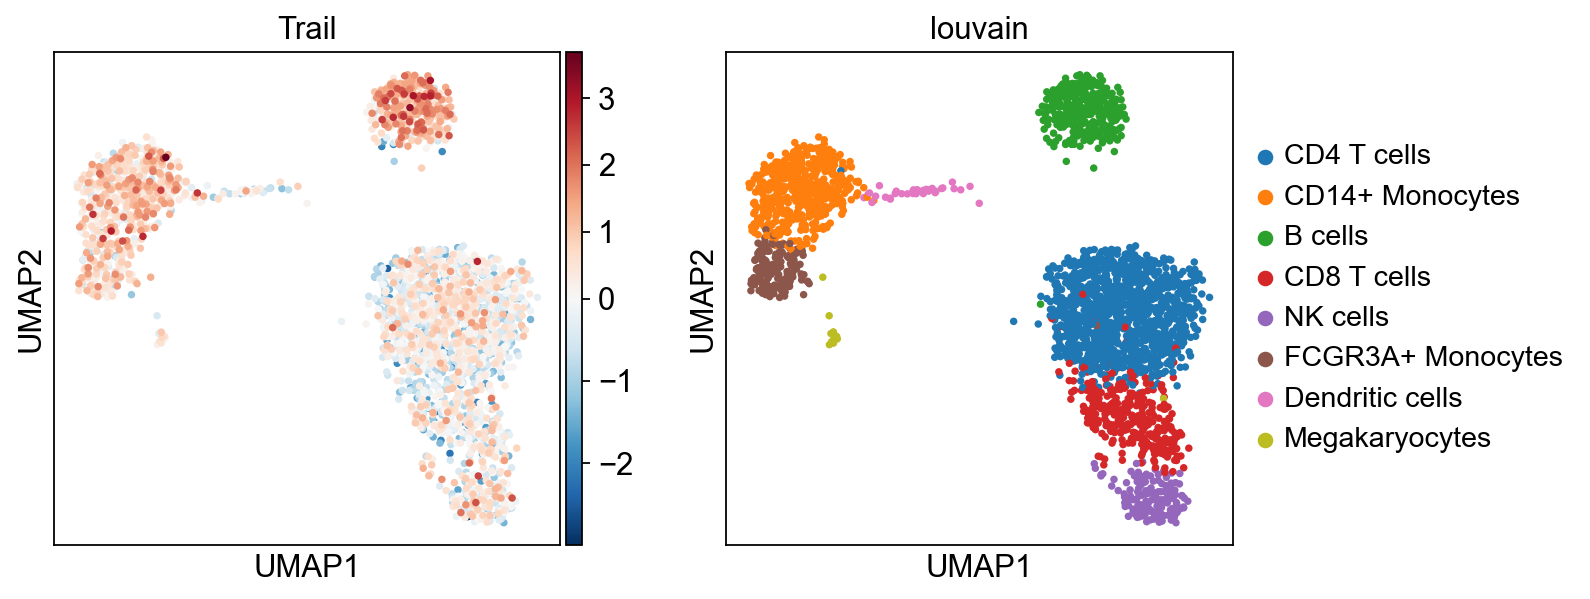

In [21]:
sc.pl.umap(acts, color=['Trail', 'louvain'], cmap='RdBu_r', vcenter=0)

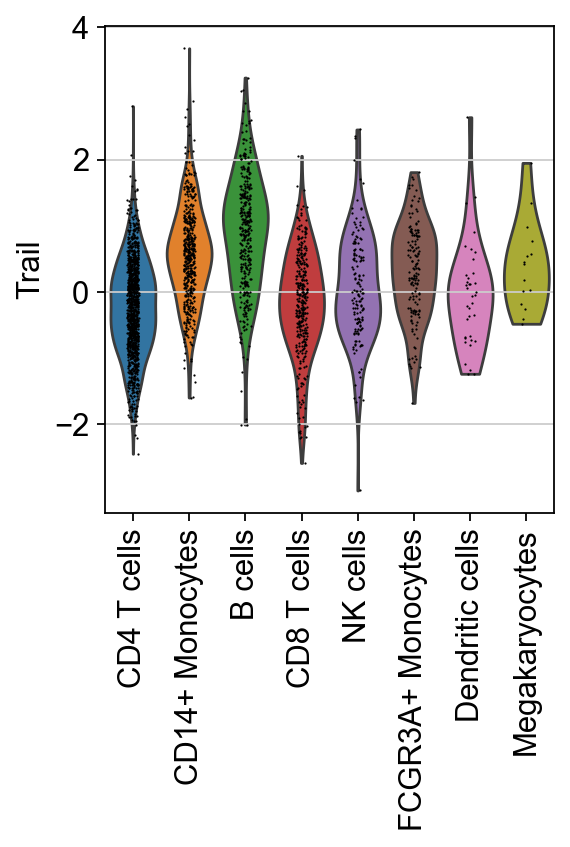

In [22]:
sc.pl.violin(acts, keys=['Trail'], groupby='louvain', rotation=90)

It seem that in B cells, the pathway Trail, associated with apoptosis, is more active.

B細胞では、アポトーシスに関連する経路Trailがより活性化しているようだ。

## Exploration

We can visualize which pathways are more active in each cell type:

それぞれの細胞タイプにおいて、どの経路がより活性化しているかを可視化することができる：

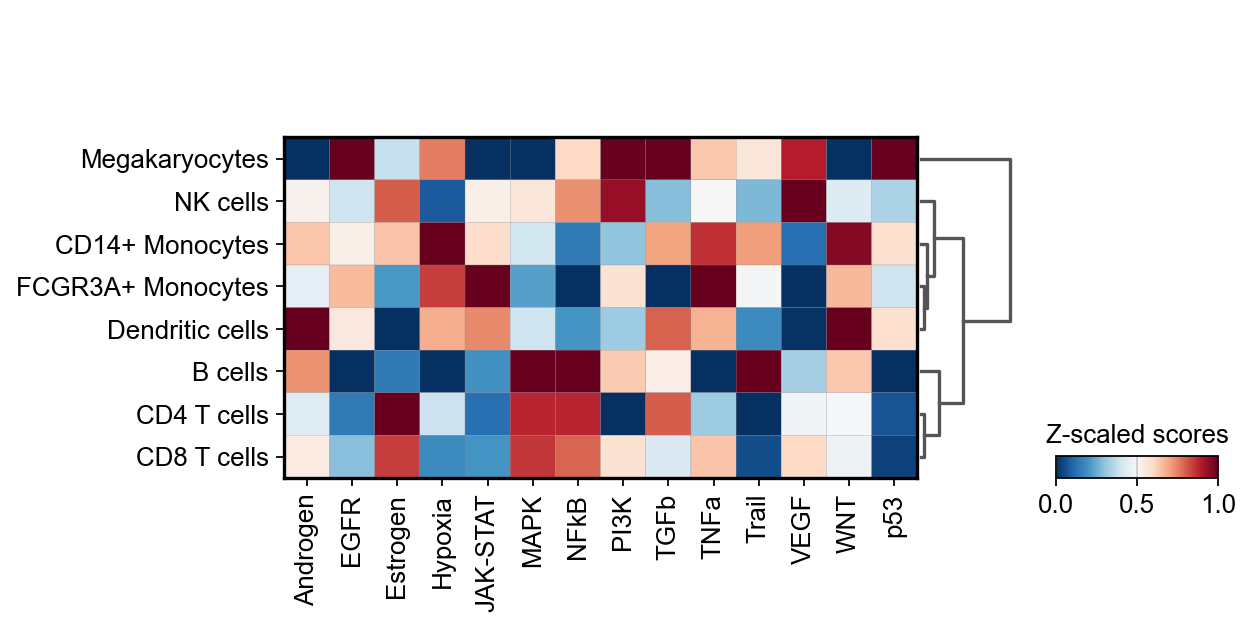

In [23]:
sc.pl.matrixplot(
    acts, var_names=acts.var_names,
    groupby='louvain', dendrogram=True, standard_scale='var',
    colorbar_title='Z-scaled scores', cmap='RdBu_r'
)

In this specific example, we can observe that EGFR to be more active in Megakaryocytes, and that Trail is more active in B cells.

Finally, we can check individual pathways by plotting their distributions:

この具体例では、EGFRはメガカリオサイトでより活性が高く、TrailはB細胞でより活性が高いことが観察できる。

最後に、分布をプロットすることによって、個々のパスウェイをチェックすることができる：

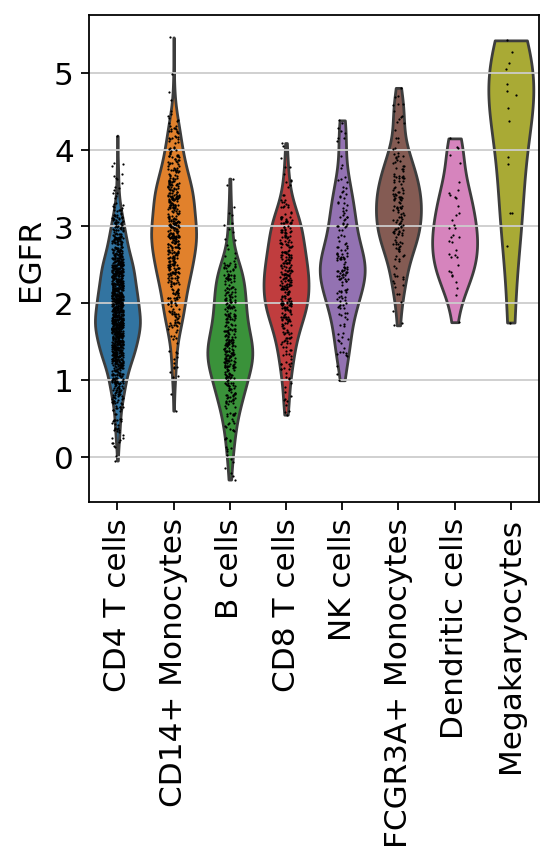

In [11]:
sc.pl.violin(acts, keys=['EGFR'], groupby='louvain', rotation=90)